In [17]:
import tensorflow as tf
import tensorflowjs as tfjs
from matplotlib import pyplot
import numpy as np
import os
import json
import visualkeras

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("data-150x150",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(150, 150),
  batch_size=32)

Found 79696 files belonging to 4 classes.
Using 63757 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory("data-150x150",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(150, 150),
  batch_size=32)

Found 79696 files belonging to 4 classes.
Using 15939 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomCrop(120, 120) #height, width; NOTE: DOESN'T WORK WITH tensorflowjs
  ]
)

In [6]:
num_classes = 4
models = {}

In [7]:
models["CNN"] = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(150,150,3)),
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [8]:
models["MLP"] = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(150,150,3)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [9]:
for model in models.values():
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
for model in models.values():
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)       

In [11]:
epochs=65
histories = {}

In [12]:
for name in models:
    print("Training "+name+":")
    model_path = os.path.join("saved_models", name)
    history_path = os.path.join("saved_histories", name+".json")
    tfjs_target_path = os.path.join("web-client", "saved_models", "layers", name)
    histories[name] = models[name].fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
    )
    models[name].save(model_path)
    models[name].save(model_path+".h5")
    tfjs.converters.save_keras_model(models[name], tfjs_target_path)
    json.dump(histories[name].history, open(history_path, 'w'))
    print()

Training CNN:
Epoch 1/65
1993/1993 [==============================] - 71s 30ms/step - loss: 0.6829 - accuracy: 0.7171 - val_loss: 0.4230 - val_accuracy: 0.8432
Epoch 2/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.4023 - accuracy: 0.8523 - val_loss: 0.3262 - val_accuracy: 0.8821
Epoch 3/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.3375 - accuracy: 0.8773 - val_loss: 0.2945 - val_accuracy: 0.8934
Epoch 4/65
1993/1993 [==============================] - 57s 29ms/step - loss: 0.3061 - accuracy: 0.8895 - val_loss: 0.2903 - val_accuracy: 0.8960
Epoch 5/65
1993/1993 [==============================] - 57s 29ms/step - loss: 0.2846 - accuracy: 0.8976 - val_loss: 0.3528 - val_accuracy: 0.8702
Epoch 6/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.2717 - accuracy: 0.9034 - val_loss: 0.2614 - val_accuracy: 0.9056
Epoch 7/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.2589 - accuracy: 0.9090 - val_

Epoch 57/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.1556 - accuracy: 0.9481 - val_loss: 0.1690 - val_accuracy: 0.9415
Epoch 58/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.1477 - accuracy: 0.9502 - val_loss: 0.1646 - val_accuracy: 0.9435
Epoch 59/65
1993/1993 [==============================] - 57s 29ms/step - loss: 0.1514 - accuracy: 0.9478 - val_loss: 0.1686 - val_accuracy: 0.9434
Epoch 60/65
1993/1993 [==============================] - 57s 29ms/step - loss: 0.1641 - accuracy: 0.9440 - val_loss: 0.1751 - val_accuracy: 0.9393
Epoch 61/65
1993/1993 [==============================] - 57s 29ms/step - loss: 0.1491 - accuracy: 0.9495 - val_loss: 0.1740 - val_accuracy: 0.9413
Epoch 62/65
1993/1993 [==============================] - 59s 29ms/step - loss: 0.1454 - accuracy: 0.9496 - val_loss: 0.1637 - val_accuracy: 0.9427
Epoch 63/65
1993/1993 [==============================] - 58s 29ms/step - loss: 0.1571 - accuracy: 0.9464 - val_loss: 0

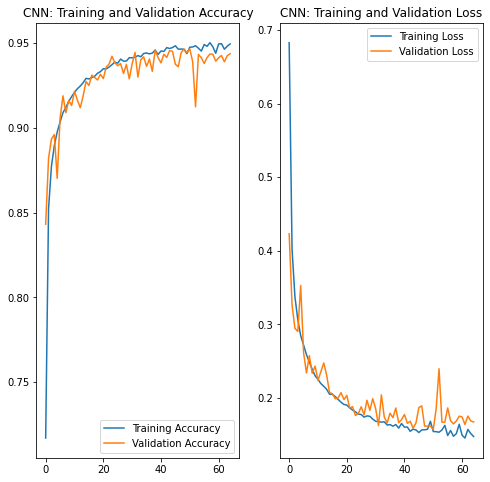

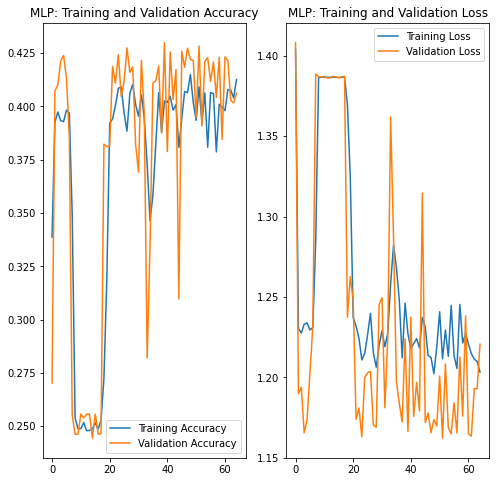

In [15]:
for name in histories:
    history = histories[name]
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    pyplot.figure(figsize=(8, 8))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(epochs_range, acc, label='Training Accuracy')
    pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
    pyplot.legend(loc='lower right')
    pyplot.title(name+': Training and Validation Accuracy')

    pyplot.subplot(1, 2, 2)
    pyplot.plot(epochs_range, loss, label='Training Loss')
    pyplot.plot(epochs_range, val_loss, label='Validation Loss')
    pyplot.legend(loc='upper right')
    pyplot.title(name+': Training and Validation Loss')
    pyplot.show()

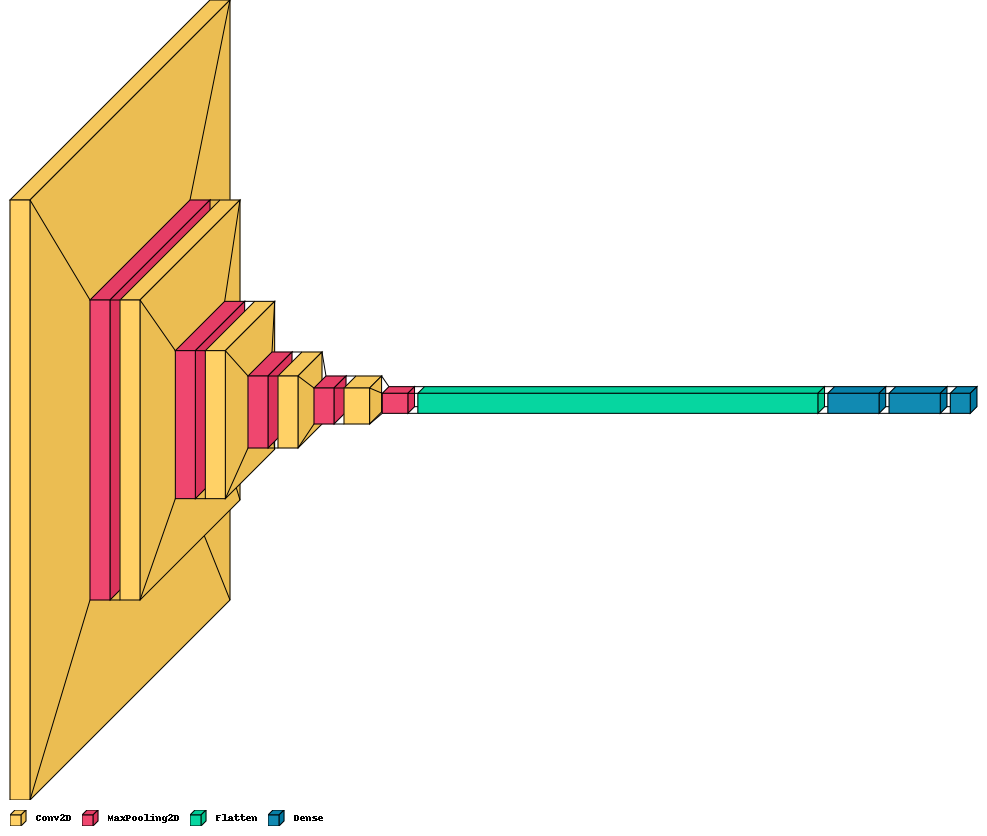

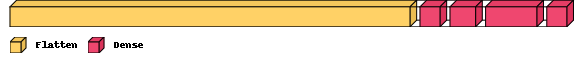

In [28]:
for name in models:
    visualkeras.layered_view(models[name], legend=True, type_ignore=[tf.keras.Sequential, tf.keras.layers.Rescaling]).show()

In [29]:
class_names = ["Wearing Mask a Correctly Over Mouth and Nose", "Wearing Mask a Over Mouth, but not Over Nose", "Not Wearing a Mask Over Mount and Nose", "Not Wearing a Mask"]

In [30]:
def predict(file_path):
    
    img = tf.keras.utils.load_img(file_path, target_size=(150, 150))
    pyplot.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    for name in models:
        model = models[name]
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])


        print(
            "{} predicts {} ({:.2f}% confidence)"
            .format(name, class_names[np.argmax(score)], 100 * np.max(score))
        )
    pyplot.show()

CNN predicts Not Wearing a Mask (54.21% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (28.40% confidence)


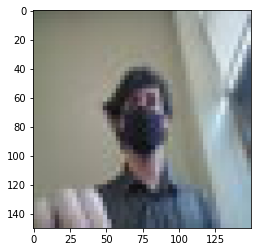

In [31]:
predict("faces/benjamin/1.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (35.46% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (30.08% confidence)


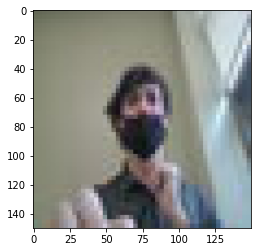

In [32]:
predict("faces/benjamin/2.jpg")

CNN predicts Not Wearing a Mask Over Mount and Nose (48.54% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (34.26% confidence)


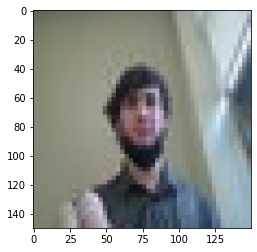

In [33]:
predict("faces/benjamin/3.jpg")

CNN predicts Not Wearing a Mask (53.93% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (36.21% confidence)


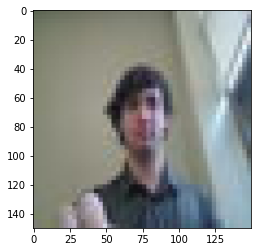

In [34]:
predict("faces/benjamin/4.jpg")

CNN predicts Wearing Mask a Correctly Over Mouth and Nose (83.35% confidence)
MLP predicts Wearing Mask a Over Mouth, but not Over Nose (33.04% confidence)


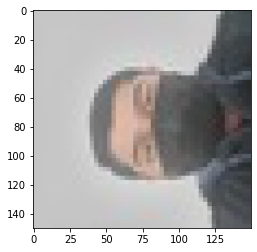

In [35]:
predict("faces/shaurya/1.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (66.41% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (31.12% confidence)


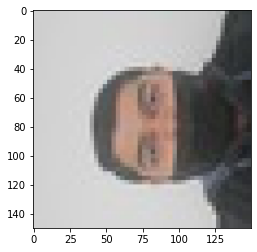

In [36]:
predict("faces/shaurya/2.jpg")

CNN predicts Not Wearing a Mask (77.73% confidence)
MLP predicts Not Wearing a Mask (38.25% confidence)


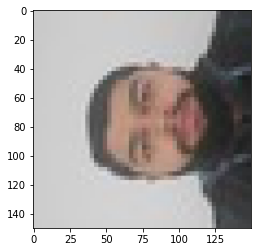

In [37]:
predict("faces/shaurya/3.jpg")

CNN predicts Not Wearing a Mask (81.55% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (32.30% confidence)


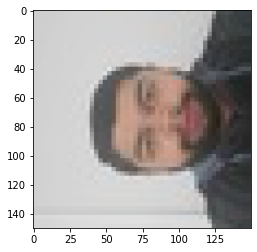

In [38]:
predict("faces/shaurya/4.jpg")

CNN predicts Wearing Mask a Correctly Over Mouth and Nose (92.31% confidence)
MLP predicts Wearing Mask a Correctly Over Mouth and Nose (91.86% confidence)


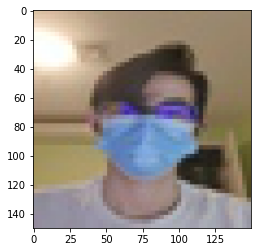

In [39]:
predict("faces/zunyi/1.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (95.54% confidence)
MLP predicts Wearing Mask a Correctly Over Mouth and Nose (80.63% confidence)


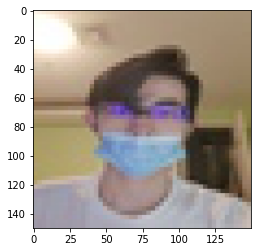

In [40]:
predict("faces/zunyi/2.jpg")

CNN predicts Not Wearing a Mask Over Mount and Nose (89.84% confidence)
MLP predicts Wearing Mask a Correctly Over Mouth and Nose (65.80% confidence)


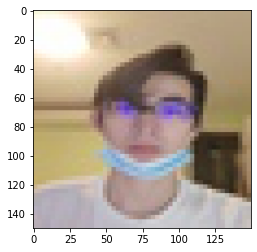

In [41]:
predict("faces/zunyi/3.jpg")

CNN predicts Not Wearing a Mask (93.50% confidence)
MLP predicts Wearing Mask a Correctly Over Mouth and Nose (48.35% confidence)


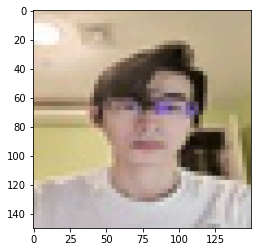

In [42]:
predict("faces/zunyi/4.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (59.84% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (29.67% confidence)


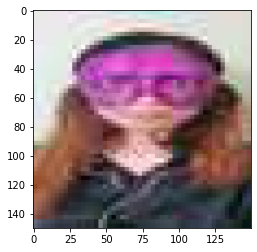

In [43]:
predict("faces/parisa/1.jpg")

CNN predicts Not Wearing a Mask (33.06% confidence)
MLP predicts Not Wearing a Mask Over Mount and Nose (29.96% confidence)


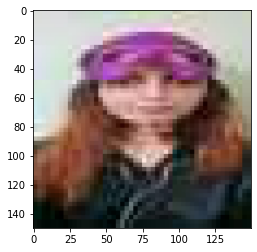

In [44]:
predict("faces/parisa/2.jpg")

CNN predicts Wearing Mask a Over Mouth, but not Over Nose (53.72% confidence)
MLP predicts Not Wearing a Mask (38.25% confidence)


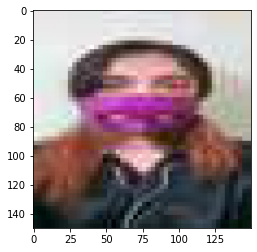

In [45]:
predict("faces/parisa/3.jpg")

## Source: https://www.tensorflow.org/tutorials/images/classification